# Time tracked trajectories - numerical solutions to the HJ equation

In [1]:
import numpy as np
import matplotlib.pyplot as py
py.style.use('small_plots.txt') #stylistic choice

Potentials $V = V_0\phi^k$, $H_{\mathrm{initial}} = 2\times10^{-5} M_{pl}$ simulating $H$ trajectories using HJ formalism with initial point in the $\phi > 0, \dot{\phi} < 0$ quadrant, so $\frac{dH}{d\phi} = \sqrt{1.5H^2 - 0.5V}$ (initially at least). We will allow the sign of $\dot{\phi}$ to change in general, in case of which the sign of $\frac{dH}{d\phi}$ would change

I'd like to ensure $\varepsilon > 0$, and I remedy this by taking an adaptive scheme whose step size becomes smaller (with given bound) as $\varepsilon$ tends to 0.

In [2]:
#Some often used functions go first
grad_calc = lambda H, V0, phi, m: (abs(1.5*(H**2) - 0.5*V0*(phi**m)))**0.5
grad_sqr = lambda H, V0, phi, m: 1.5*(H**2) - 0.5*V0*(phi**m)
epsilon_calc = lambda  H, V0, phi, m: 2*(abs(1.5*(H**2) - 0.5*V0*(phi**m))/(H**2))
g = lambda x: x if x>0.00001 else 0.00001
def f(H, V0, phi, m):
    '''Interpolation of step-size so that particularly small ε values have small enough step sizes. 
    This could be particularly helpful with ϕ^m potentials for small m>0'''
    returnval = (0.5**((0.0001/g(epsilon_calc(H, V0, phi, m))))) if epsilon_calc(H, V0, phi, m) < 0.0001 else 0.5
    return returnval

Below is the main algorithm. I have included updated `trajectory` and `tot_traj` functions - they include parameter check suppression options(`suppress`), but more importantly and `epsilonstop` option which runs the $H$ trajectory from the end of inflation back to $\varepsilon = 1$, which is inflation as per its definition in the formal model, rather than ending inflation after a predecided number of e-folds.

We scale $H \rightarrow H \times 10^5 = \tilde{H}$, $V_0 \rightarrow V_0 \times 10^{10} = \tilde{V_0}$ for convenience

In [3]:
def trajectory(V_0, m, phi_0, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2, suppress = False):
    '''The first stage is to integrate forwards in time, to the end of inflation. We use and RK4 adaptive-step integrator,
    but the step size adapts according to ε rather than some error estimate.'''
    #
    #We check whether the initial point is in the right domain
    #
    if not (3*(H0**2)/((phi_0)**m) > V_0 > 2*(H0**2)/((phi_0)**m) or suppress):
        raise Exception("wrong parameter choice")
    #Initialise some zero arrays - we choose the maximal size dependent on the initial ϕ, initial step size (so to fit in a weak lower bound
    #number of steps before ϕ = 0) and an input 'boundmultiplier' default 100
    #
    T =  int(phi_0/dphi0)
    phi = np.zeros(boundmultiplier*T+1)  #adapting ϕ mesh
    H = np.zeros(boundmultiplier*T+1) #H values
    phi[0] = phi_0 #initial ϕ
    H[0]  = H0 #initial H
    epsilon = epsilon_calc(H[0], V_0, phi[0], m) #initial epsilon
    #
    n = 0
    dphi = dphi0
    #SPACE
    while (epsilon < 1) and (n < boundmultiplier*T):
        #Here we make successive gradient estimates, as per RK integration, using grad_calc to calculate the gradient at a point
        #
        K1 = grad_calc(H[n], V_0, phi[n], m)
        K2 = grad_calc(H[n] - 0.5*dphi*K1, V_0, phi[n] - 0.5*dphi, m)
        K3 = grad_calc(H[n] - 0.5*dphi*K2, V_0, phi[n] - 0.5*dphi, m)
        K4 = grad_calc(H[n] - dphi*K3, V_0, phi[n] - dphi, m)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        #Currently, we are moving forwards in time, corresponding to decreasing ϕ
        #
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] - dphi
        epsilon = epsilon_calc(H[n+1], V_0, phi[n+1], m)
        coeff = f(H[n+1], V_0, phi[n+1], m)
        #Here, we change dphi so that its new value would not make it cross the ε = 0 contour, and our choice of coefficient hopefully ensures
        #that it doesn't cross the separatrix for this potential
        #
        dphi = min(coeff*(H[n+1] - ((V_0*(phi[n+1])**m)*(1/3))**0.5)/(grad_calc(H[n+1], V_0, phi[n+1], m)), dphi0)
        n += 1
    return phi[0:n+1], H[0:n+1], n, epsilon #after the nth value of phi, H (if such exists) the values are the initial, meaningless zero values

def tot_traj(Nstart, V_0, m, phi_0 = 15, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2, suppress = False, epsilonstop = False):
    '''This function takes a solution from    trajectory()   , parametrises it by N, and integrates backwards (parametrising by N) to achieve
    a piece of the trajectory corresponding to earlier times'''
    T = int(phi_0/dphi0)
    gradpositive = True #to be explained
    phiswap, Jswap, n0, epsilon = trajectory(V_0, m, phi_0, dphi0, boundmultiplier, H0, suppress)
    #
    #swap order of phi array and H array - we are about to integrate backwards in time
    phi1, J1 = phiswap[::-1], Jswap[::-1]
    #
    #W start at the end of inflation, so we start at N = 0
    #Initialise arrays to bound the memory we will need
    N = np.zeros(boundmultiplier*T + 1)
    phi = np.zeros(boundmultiplier*T + 1)
    H = np.zeros(boundmultiplier*T + 1)
    ε = np.zeros(boundmultiplier*T + 1)
    #we have our phi values up to phi_0 and the corresponding H values already
    phi[:n0 + 1] = phi1
    H[:n0 + 1] = J1
    #assign epsilon at the start of the scheme, the end of infaltion
    ε[0] = epsilon
    #Initialise number of steps n
    n = 0
    n_sgn_change = boundmultiplier*T + 1
    while (N[n] < Nstart) and (n < n0):
        #Here we are just reparametrising the H trjectory we already have
        dphi = phi[n+1] - phi[n]
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], m)
        #
        #we have what is effectively an RK2 scheme here - the error at each step of this loop is not intrinsically dependent
        #on the error of earlier steps, so there isn't as much reason to choose a high order integrator here as there is in
        #integrating the HJ equation
        #
        E1 = (2 / ε[n])**0.5
        E2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(E1 + E2)/4
        n += 1
    #
    #
    '''Next we make a series of checks:
    
    - (gradpositive = True) tells is that the standard scheme predicts sensible H', so we can continue as before
    
    -The (N < Nstart) check puts a time limit on the time span we consider; the scheme should stop at N = Nstart
    
    -A very large upper bound is chosen, linear in each of    boundmultiplier   and    phi_0
    
    -Inflation should not occur for ε > 1, so the default setting is that too large an ε will end the scheme, but by
    setting   (epsilonstop = False)   backwards integration will continue past this point'''
    #
    #
    while gradpositive and (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        while (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
            #
            #The next check allows us to skip time-consuming checks if epsilon is clearly still not close to zero. In the unlikely case of
            #fatal errors, increasing the lower bound of the below epsilon check may help
            #
            if ε[n] > 0.001:
                dphi = min(0.5*(H[n] - ((V_0*(phi[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], m)), dphi0)
                #RK4 section
                #
                K1 = grad_calc(H[n], V_0, phi[n], m)
                K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, m)
                K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, m)
                K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, m)
                grad = (K1 + 2*K2 + 2*K3 + K4)/6
                H[n+1] = H[n] + dphi*grad
                phi[n+1] = phi[n] + dphi
                #
                ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], m)
                #
                #RK2 section
                #
                E1 = (2 / ε[n])**0.5
                E2 = (2 / ε[n+1])**0.5
                N[n+1] = N[n] + dphi*(E1 + E2)/4
                n += 1
            else:
               #At this stage, ε has become very small. We check at each stage whether we are going to pass phidot = 0, in which case we note this
                #and continue so that we may return to assume a change in sign
                coeff = f(H[n], V_0, phi[n], m)
                dphi = min(coeff*(H[n] - ((V_0*(phi[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], m)), dphi0)
                #
                #We check whether the next gradient estimate corresponds to H' > 0. If so, we may proceed (and check the same for the other
                #gradient estimates), but as soon as a negative estimate is made we note this and will change the integrator
                if grad_sqr(H[n], V_0, phi[n], m) > 0:
                    K1 = grad_calc(H[n], V_0, phi[n], m)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, m):
                    K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, m)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, m):
                    K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, m)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + dphi*K3, V_0, phi[n] + dphi, m):
                    K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, m)
                else:
                    gradpositive = False
                    break
                grad = (K1 + 2*K2 + 2*K3 + K4)/6
                H[n+1] = H[n] + dphi*grad
                phi[n+1] = phi[n] + dphi
                ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], m)
                #SPACE
                J1 = (2 / ε[n])**0.5
                J2 = (2 / ε[n+1])**0.5
                N[n+1] = N[n] + dphi*(J1 + J2)/4
                n += 1
     #
    #once we note the unavoidable change in sign is imminent, we approximate phi constant, H' takes the negative of its last value,
    #so H is unchanged - see the associated dissertation for justification
    #
    if (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        H[n] = H[n-1]
        phi[n] = phi[n-1]
        ε[n] = ε[n - 1]
        #
        #Record the index when the sign of H' changes
        n_sgn_change = n
        #
        #Calculate the number of e-folds passed, as per the associated dissertation
        N[n] = N[n-1] + (4*grad_calc(H[n-1], V_0, phi[n-1], m)*((V_0*(phi[n-1])**m)**0.5))/((3**0.5)*((m*V_0*(phi[n-1])**(m-1))**0.5))
        #
        #In this final loop, we take the equivalent of dphi -> -dphi, H' takes negative square root
        #
    while (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        #step size
        dphi = min(0.5*(H[n] - ((V_0*(phi[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], m)), dphi0)
        #
        #RK4
        #
        K1 = -grad_calc(H[n], V_0, phi[n], m)
        K2 = -grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, m)
        K3 = -grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, m)
        K4 = -grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, m)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] - dphi
        #
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], m)
        #
        #RK2
        #
        E1 = (2 / ε[n])**0.5
        E2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(E1 + E2)/4
        #
        n += 1
    return phi[:n+1], H[:n+1], n, ε[:n+1], N[:n+1], n_sgn_change

Next, I show an example implementation and its conversion to a $\phi - \dot{\phi}$ plane trajectory. To get this, we rescale $\dot{\phi} \rightarrow \dot{\phi} \times 10^{5} = \tilde{\dot{\phi}}$

Final n = 143716
Final N = 55.96140758342712 ,
Final H = 2.4319682618911966 ,
Final ϕ = 15.380899999999112
Solution of desired number of e-folds not available via this method - ε > 1 at n = 143716. Will need to select different parameters to get a solution corresponding to a greater amount of inflation or select `epsilonstop = False' 


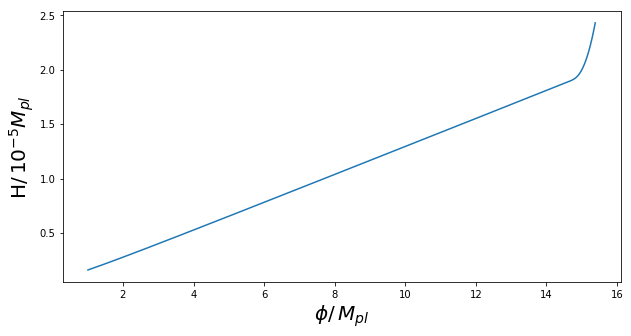

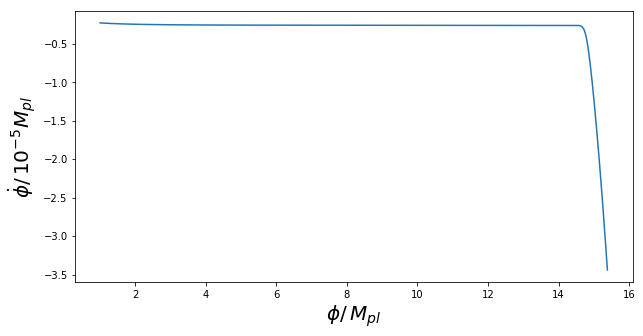

In [4]:
mchoice = 2
V0choice = 0.05

#phi, H are vectors of length n+1 which together describe the numerical solution to the HJ equation with parameters input on the right
#
figH = py.figure(figsize = (10, 5))
phi, H, n, epsilon, N , n_sgn= tot_traj(60, V0choice, mchoice, phi_0 = 15, suppress = False, epsilonstop = True) 
py.plot(phi, H)
py.xlabel('$\phi/\, M_{pl}$')
py.ylabel('H/$\, 10^{-5}M_{pl}$')

#Next, we convert the solution generated above to the phi - phidot plane. See dissertation 5.6 for details
figalt = py.figure(figsize = (10, 5))
Vset = [V0choice*ϕ**mchoice for ϕ in phi]
phidot = [-(6*((H[i])**2) - 2*(Vset[i]))**0.5 if i<n_sgn else (6*((H[i])**2) - 2*(Vset[i]))**0.5 for i in range(len(phi))]
py.plot(phi, phidot)
py.xlabel('$\phi/\, M_{pl}$')
py.ylabel('$\dot{\phi}/\,10^{-5} M_{pl}$')



print("Final n =", n, end = '\n')
print("Final N =", N[-1], ',')
print('Final H =', H[-1], ',')
print('Final ϕ =', phi[-1], end = '\n')
for i, el in enumerate(epsilon):
    if el >1 and i>0:
        print("Solution of desired number of e-folds not available via this method - ε > 1 at n = %s. Will need to select different parameters to get a solution corresponding to a greater amount of inflation or select `epsilonstop = False' "%i)
        break

Users may find the following plot, and information in the disseration associated with this notebook, helpful in choosing appropriate parameters

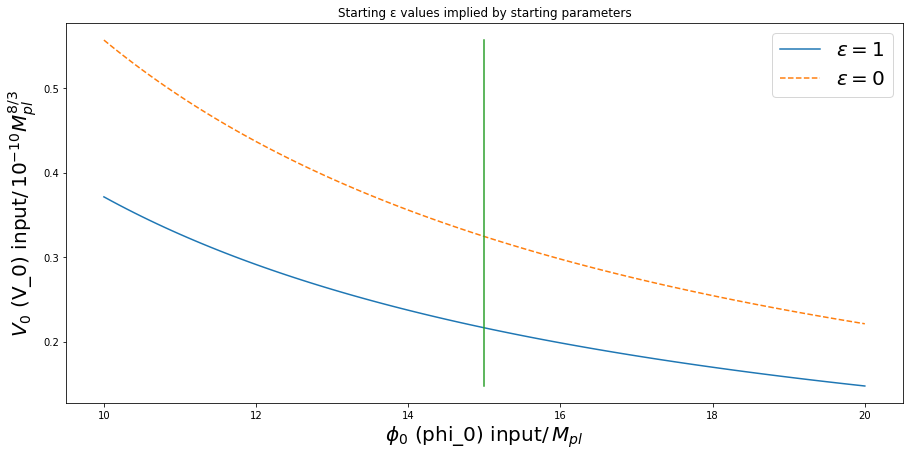

In [5]:
#consider choices of m
h60 = 2
m= 4/3
linechoice = 15

phi60 = np.linspace(10, 20, 101)
Vzero = [(h60**2)*2/(phi**m) for phi in phi60]
Vzero2 = [(h60**2)*3/(phi**m) for phi in phi60]

py.style.use('small_plots.txt')

figgy = py.figure(figsize = (15, 7))
py.plot(phi60, Vzero, label = '$ε = 1$')
py.plot(phi60, Vzero2, '--', label = '$ε = 0$')
py.plot(np.linspace(linechoice, linechoice, 11), np.linspace(Vzero[-1], Vzero2[0], 11))
py.xlabel('$\phi_0$ (phi_0) input$/\, M_{pl}$')
py.ylabel('$V_0$ (V_0) input$/\, 10^{-10}M_{pl}^{8/3}$') #The exponent
py.title('Starting ε values implied by starting parameters')
py.legend()

## $N$ parametrised trajectories of $\phi$, $\dot{\phi}$ and $H$

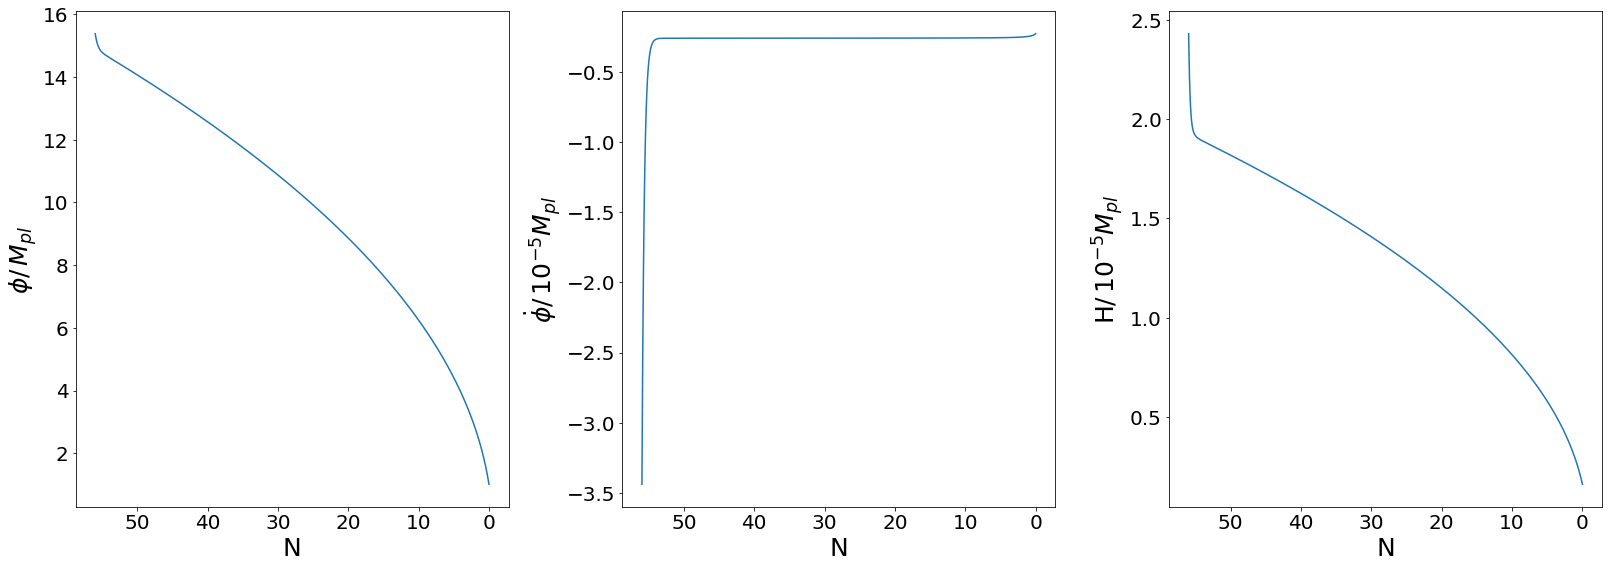

In [6]:
py.style.use('subplotlabels.txt')

#Now we parametrise by N, plotting 
Ntraj, Nax = py.subplots(1,3, figsize = (22.5, 8))
Nax[0].plot(N, phi)
Nax[0].set(xlabel ='N', ylabel = '$\phi/\, M_{pl}$')
Nax[0].invert_xaxis()

Nax[1].plot(N, phidot)
Nax[1].set(xlabel = 'N', ylabel = '$\dot{\phi}/\, 10^{-5} M_{pl}$')
Nax[1].invert_xaxis()

Nax[2].plot(N, H)
Nax[2].set(xlabel = 'N', ylabel = 'H/$\, 10^{-5}M_{pl}$')
Nax[2].invert_xaxis()

Ntraj.tight_layout()

n = 119829
N = 60.00008645895739


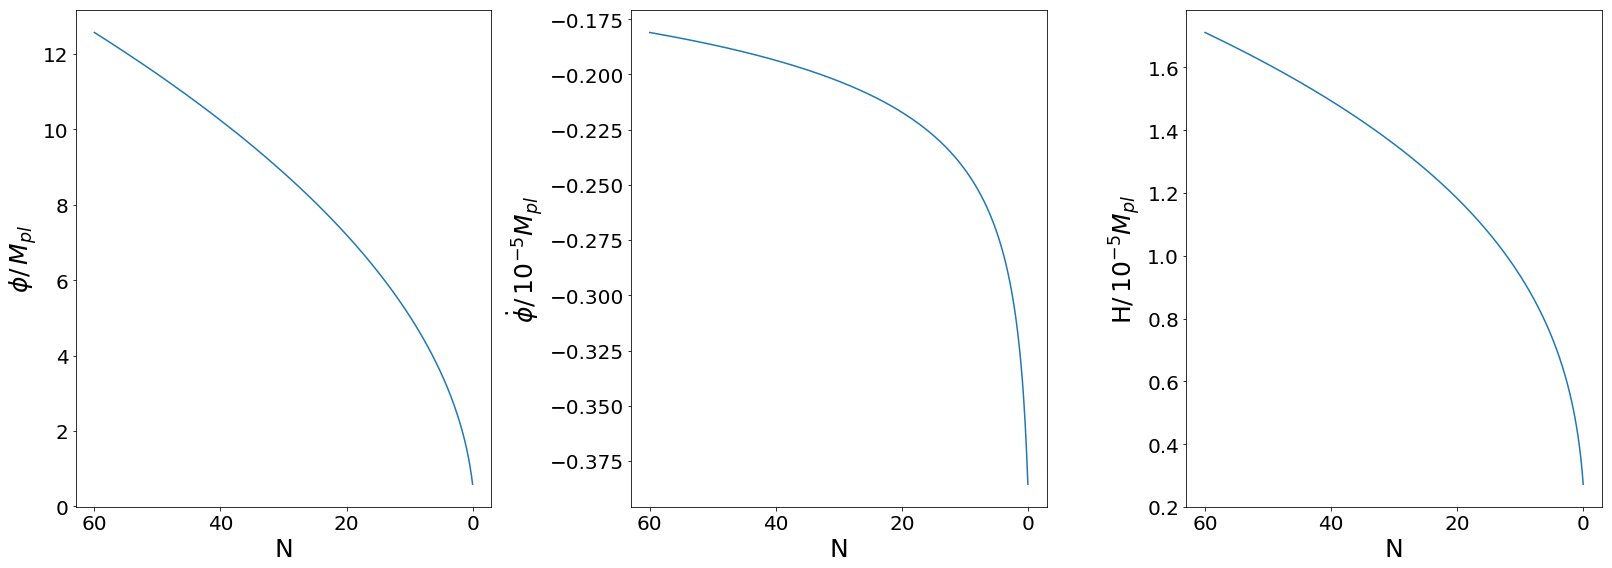

In [7]:
#As before, but new parameters
mchoice = 4/3
V0choice = 0.3

phi, H, n, epsilon, N , n_sgn= tot_traj(60, V0choice, mchoice, phi_0 = 15, suppress = False, epsilonstop = True)
Vset = [V0choice*ϕ**mchoice for ϕ in phi]
phidot = [-(6*((H[i])**2) - 2*(Vset[i]))**0.5 if i<n_sgn else (6*((H[i])**2) - 2*(Vset[i]))**0.5 for i in range(len(phi))]

print("n =", n, end = '\n')
print("N =", N[-1], end = '\n')
for i, el in enumerate(epsilon):
    if el >1 and i>0:
        print("Full trajectory not available via this method - ε > 1 at n = %s"%i)
        break

Ntraj, Nax = py.subplots(1,3, figsize = (22.5, 8))
Nax[0].plot(N, phi)
Nax[0].set(xlabel ='N', ylabel = '$\phi/\, M_{pl}$')
Nax[0].invert_xaxis()

Nax[1].plot(N, phidot)
Nax[1].set(xlabel = 'N', ylabel = '$\dot{\phi}/\, 10^{-5} M_{pl}$')
Nax[1].invert_xaxis()

Nax[2].plot(N, H)
Nax[2].set(xlabel = 'N', ylabel = 'H/$\, 10^{-5}M_{pl}$')
Nax[2].invert_xaxis()

Ntraj.tight_layout()